## **Paper:** Multi-objective Parameter Tuning with Dynamic Compositional Surrogate Models

In [4]:
import glob
import sys
# sys.path.append('..')
sys.path.append('src')

import pandas as pd
import numpy as np
import pygmo as pg
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
sns.set_context("talk")


from plotly import graph_objs as go
import plotly.express as px

from src.composite import ModelsUnion

def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)
def make_nd_pop(pro, x, y):
    nd_front = pg.fast_non_dominated_sorting(y)[0][0]
    nd_x = np.array(x)[nd_front]
    nd_y = np.array(y)[nd_front]
    t_pop = pg.population(pro)
    for i, p_vector in enumerate(nd_x):
        t_pop.push_back(x=p_vector, f=nd_y[i])
    return t_pop

import re
import ast
def str2array(s):
    # Remove space after [
    s=re.sub('\[ +', '[', s.strip())
    # Replace commas and spaces
    s=re.sub('[,\s]+', ', ', s)
    return np.array(ast.literal_eval(s))

def add_ndf_size(hmapper_df):   
    map_copy = hmapper_df.copy()
    ndf_size = []
    for i in range(len(map_copy)):
        if i < 2:
            ndf_size.append(1)     
        else:
            temp_obj = map_copy.iloc[:i+1][['f1','f2']].values
            index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(temp_obj)           
            ndf_size.append(len(index_ndf[0])) # 0 - last best pareto front
    map_copy['ndf_size'] = ndf_size
    return map_copy

### Colect results
It should be noted that in the tables the `hypervolume` value is expressed in accordance with the **currently** evaluated samples. This means that to compare *multiple* optimization experiments, we need to calculate a **common reference point** and recalculate all hypervolume values.

In [6]:
def get_data(path):
    df_group = [pd.read_pickle(i_path) for i_path in glob.glob(path)]
    return pd.concat(df_group)

# --- TutorM
b1_df = get_data('./data/tutorm/paper/bench_1/WFG12_10_paper_tutor_loop.*.pkl')
b2_df = get_data('./data/tutorm/paper/bench_2/WFG12_10_paper_tutor_loop.*.pkl')
b3_df = get_data('./data/tutorm/paper/bench_3/WFG12_10_paper_tutor_loop.*.pkl')
b4_df = get_data('./data/tutorm/default_tutor/*/WFG12_10_default_tutor_loop.*.pkl')

# --- Fix model
# [1] lathin hypercube sampling (lhs)
# fix_model = get_data('./data/tutorm/paper/ndf_model_lhs_100_wfg1/WFG12_10_paper_tutor_loop.*.pkl')
# fix_model['model name'] = fix_model['model name'].astype(str)
# == lhs end

# [2] sobol sampling
# ===================== Etalon
keys = get_data('./data/tutorm/paper/solo_model_WFG1/lhs_init100/WFG12_10_paper_tutor_loop.*.pkl')[['params hash', 'model name']]
keys['params hash'] = keys['params hash'].astype(str)
keys['model name'] = keys['model name'].astype(str)
keys.drop_duplicates(inplace=True, ignore_index=True)

target = get_data('./data/tutorm/paper/solo_model_WFG1/sobol_init100/dropped_name/WFG12_10_paper_tutor_loop.*.pkl')
target['params hash'] = target['params hash'].astype(str)
target.drop('model name', axis=1, inplace=True)

fix_model = pd.merge(target, keys, how='left', on='params hash')
df_svr = get_data('./data/tutorm/paper/solo_model_WFG1/sobol_init100/WFG12_10_paper_solo_loop.*.pkl')
df_svr['model name'] = df_svr['model name'].astype(str)
fix_model = pd.concat([fix_model,df_svr])
fix_model = fix_model[fix_model['model name']!="nan"]
# == sobol end


# --- NSGA2
nsga2_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals<=1000')
nsga2_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
# baseline for reference point
baseline_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals==50000')
baseline_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)

# --- Hypermapper
mapper_path = './data/hypermapper/all_5x/WFG1_*_output_samples.csv'
mapper_df = pd.concat([add_ndf_size(pd.read_csv(i_path)) for i_path in glob.glob(mapper_path)])

# select 5 experiments (available 10)
selection = b4_df['tutor_id'].unique()[:5]
b4_df = b4_df[b4_df['tutor_id'].isin(selection)]

# --- Approach/Group columns for plots
b1_df = b1_df.assign(approach='TutorM: ndf init:100', group='tutorm')
b2_df = b2_df.assign(approach='TutorM: stack init:100', group='tutorm')
b3_df = b3_df.assign(approach='TutorM: stack+val init:100', group='tutorm')
b4_df = b4_df.assign(approach='TutorM: stack+val init:0', group='tutorm')

nsga2_df = nsga2_df.assign(approach='nsga2', group='competitor')
mapper_df = mapper_df.assign(approach='Hypermapper', group='competitor')
fix_model = fix_model.assign(approach=fix_model['model name'], group='static')

# --- Common reference points for all experiments (benchmarks 1, 2, 3, 4)
tutorm_objectives = np.concatenate([np.concatenate(df.pop_ndf_y.values) for df in [b1_df, b2_df, b3_df, b4_df, fix_model]])
all_objectives = np.concatenate([tutorm_objectives, nsga2_df[['f1', 'f2']].values, baseline_df[['f1', 'f2']].values, mapper_df[['f1', 'f2']].values])
ref_point = np.amax(all_objectives, axis=0).tolist()

# --- Update Hypervolume
def upd_hypervolume(row, ref_point):
    hypervolume = pg.hypervolume(row['pop_ndf_y']).compute(ref_point) 
    row.hypervolume = hypervolume
    return row

def upd_hypervolume_moea(focus_df, ref_point):   
    df_copy = focus_df.copy()      
    obj = df_copy[['f1', 'f2']].values
    hypervolume = []
    for i in range(len(df_copy)):
        if i < 2:
            hypervolume.append(0)   
        else:
            hypervolume.append(pg.hypervolume(obj[:i+1]
                                         ).compute(ref_point))         
    df_copy['hypervolume'] = hypervolume  
    return df_copy

b1_df = b1_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b2_df = b2_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b3_df = b3_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
b4_df = b4_df.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)
fix_model = fix_model.apply(lambda row: upd_hypervolume(row, ref_point), axis=1)


nsga2_df = upd_hypervolume_moea(nsga2_df, ref_point)
mapper_df = upd_hypervolume_moea(mapper_df, ref_point)
mapper_df = mapper_df.reset_index().rename(columns={"index": "i_fevals"})
mapper_df.i_fevals = mapper_df.i_fevals + 1
mapper_df = mapper_df.query('i_fevals>=100')

# --- Sort values for proper plotting
b1_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b2_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b3_df.sort_values(by='i_fevals', ascending=False, inplace=True)
b4_df.sort_values(by='i_fevals', ascending=False, inplace=True)
fix_model.sort_values(by='i_fevals', ascending=False, inplace=True)
mapper_df.sort_values(by='i_fevals', ascending=False, inplace=True)

ValueError: No objects to concatenate

### Rescale Hypervolume

- **max** is hypervolume from NSGA2 with `50 000` functions evalutions
- **min** is minimal hypervolume from non-dominated solutions in 10 random points

![eq](https://a8h2w5y7.rocketcdn.me/wp-content/uploads/2015/11/normalize-data.png)

In [56]:
# ---- Baseline [Max]
# baseline_df = pd.read_csv('./data/moea/concat/nsga2_on_WFG1_22_750k.csv').query('i_fevals==50000')
# baseline_df.rename(columns={"f_0": "f1", "f_1": "f2"}, inplace=True)
max_hv = baseline_df.groupby(['group_id']).apply(upd_hypervolume_moea, ref_point).mean().hypervolume

# ---- Min
udp = pg.wfg(prob_id=1, dim_dvs=2, dim_obj=2, dim_k=1)  # == WFG
pro = pg.problem(udp)
pop = pg.population(pro, size=10, seed=42)
min_hv = pg.hypervolume(make_nd_pop(pro, pop.get_x(), pop.get_f()).get_f()).compute(ref_point)

for temp_df in [b1_df, b2_df, b3_df, b4_df, fix_model, nsga2_df, mapper_df]:
    temp_df['hypervolume'] = ((temp_df['hypervolume']-min_hv)/(max_hv-min_hv))

## Static single and compositional models
 \+ NSGA2 and Hypermapper 2.0

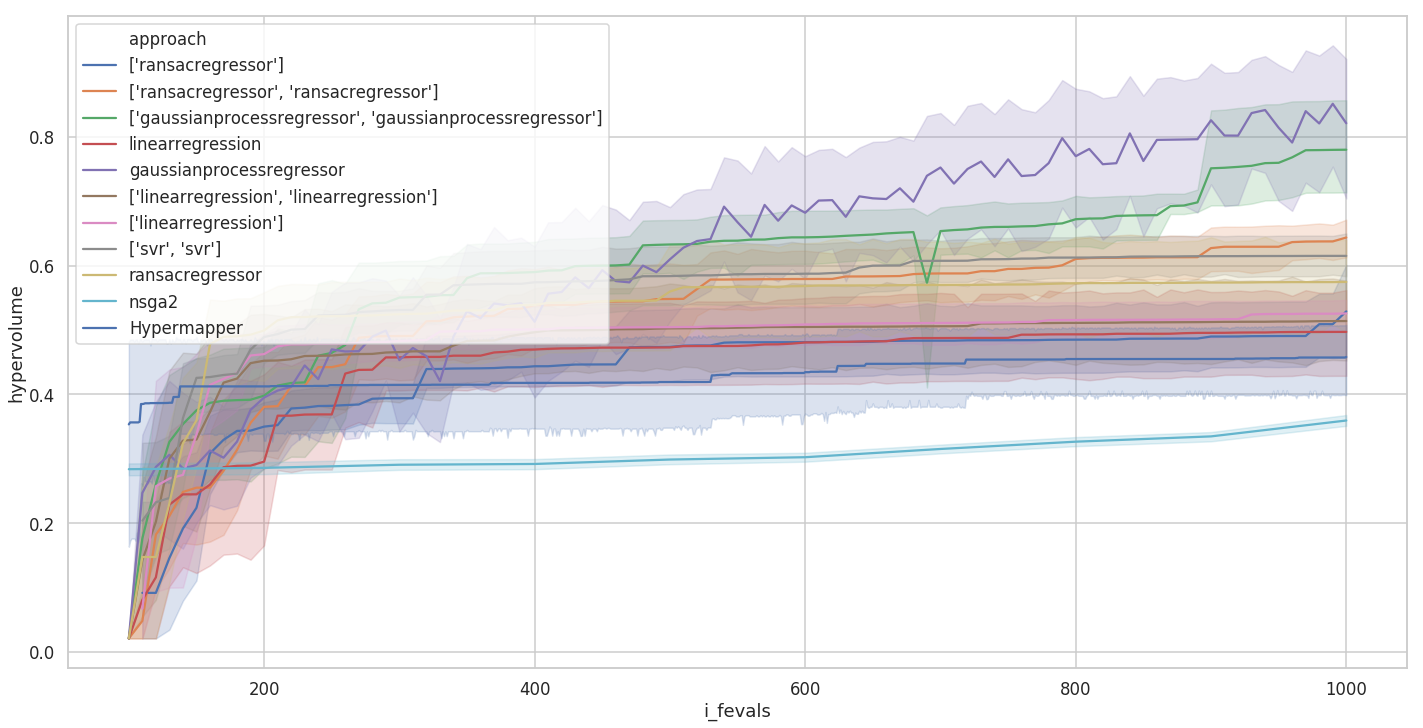

In [57]:
plt.figure(figsize=(24, 12))
sns.lineplot(x="i_fevals", y="hypervolume", hue="approach", markers=True,
             palette="deep", 
             data=pd.concat([fix_model, nsga2_df, mapper_df]))

___
## Portfolio with single and compositional models
 \+ NSGA2 and Hypermapper 2.0

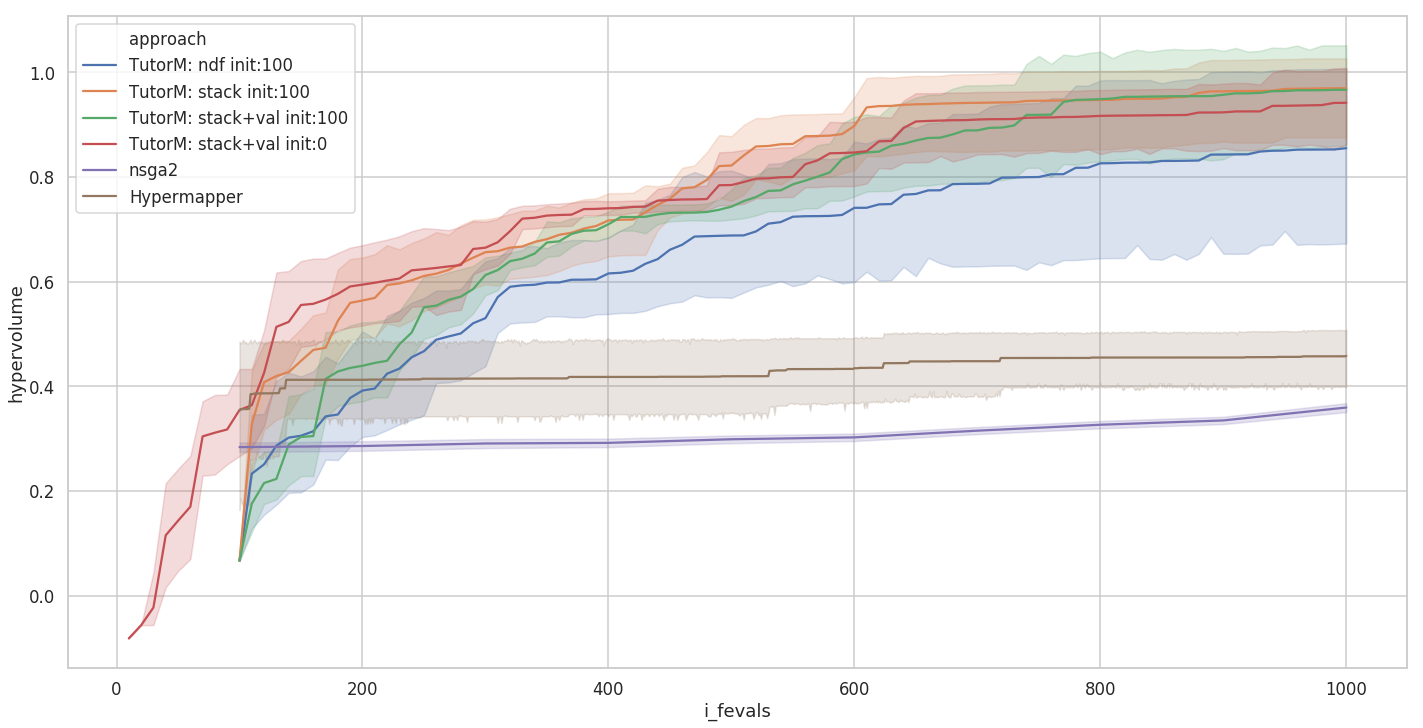

In [5]:
plt.figure(figsize=(24, 12))
sns.lineplot(x="i_fevals", y="hypervolume", hue="approach", markers=True,
             palette="deep",
             data=pd.concat([b1_df, b2_df, b3_df, b4_df, nsga2_df, mapper_df]))

___
## Overall comparison: Portfolio(TutorM) vs Static surrogate

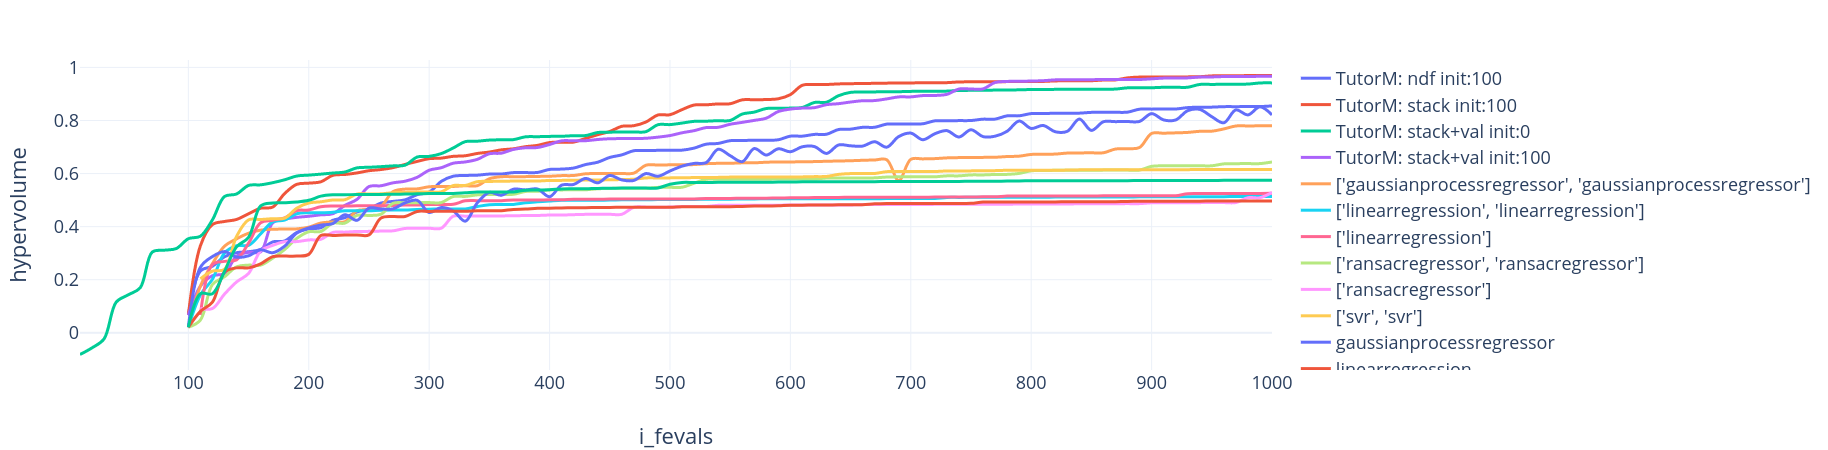

In [6]:
start_plot = px.line(pd.concat([b1_df, b2_df, b3_df, b4_df, fix_model]).groupby(['approach', 'i_fevals']).mean().reset_index(),  
            x="i_fevals", 
            y="hypervolume",
                     color='approach',
#             hover_name="i_time", 
#             color_discrete_sequence=['rgb(150,0,90)', 'rgb(0,0,200)',  'rgb(151,255,0)', 'rgb(255,234,0)', 'rgb(255,111,0)', '#fe88ec'],
            template="presentation+plotly_white",
            line_shape="spline", 
            render_mode="svg")
start_plot

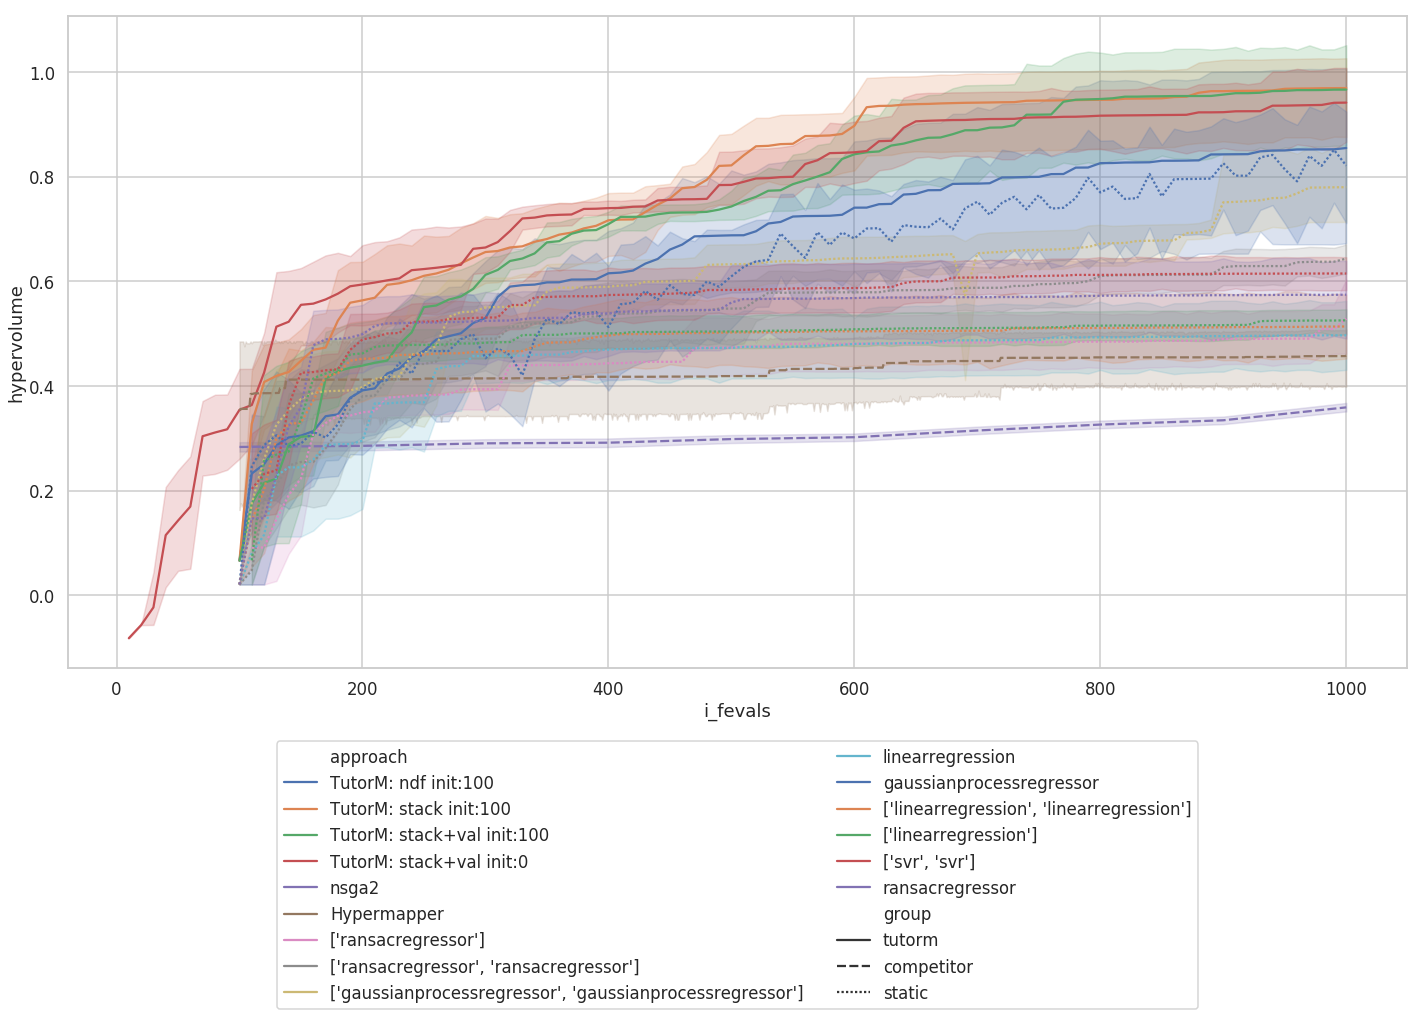

In [58]:
plt.figure(figsize=(24, 12))

p = sns.lineplot(data=pd.concat([b1_df, b2_df, b3_df, b4_df, nsga2_df, mapper_df, fix_model]),
                 x="i_fevals", y="hypervolume", 
                 hue="approach", 
#                  style='group',
                 palette="deep",
             )
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=2)
plt.show(p)

## Extra plots

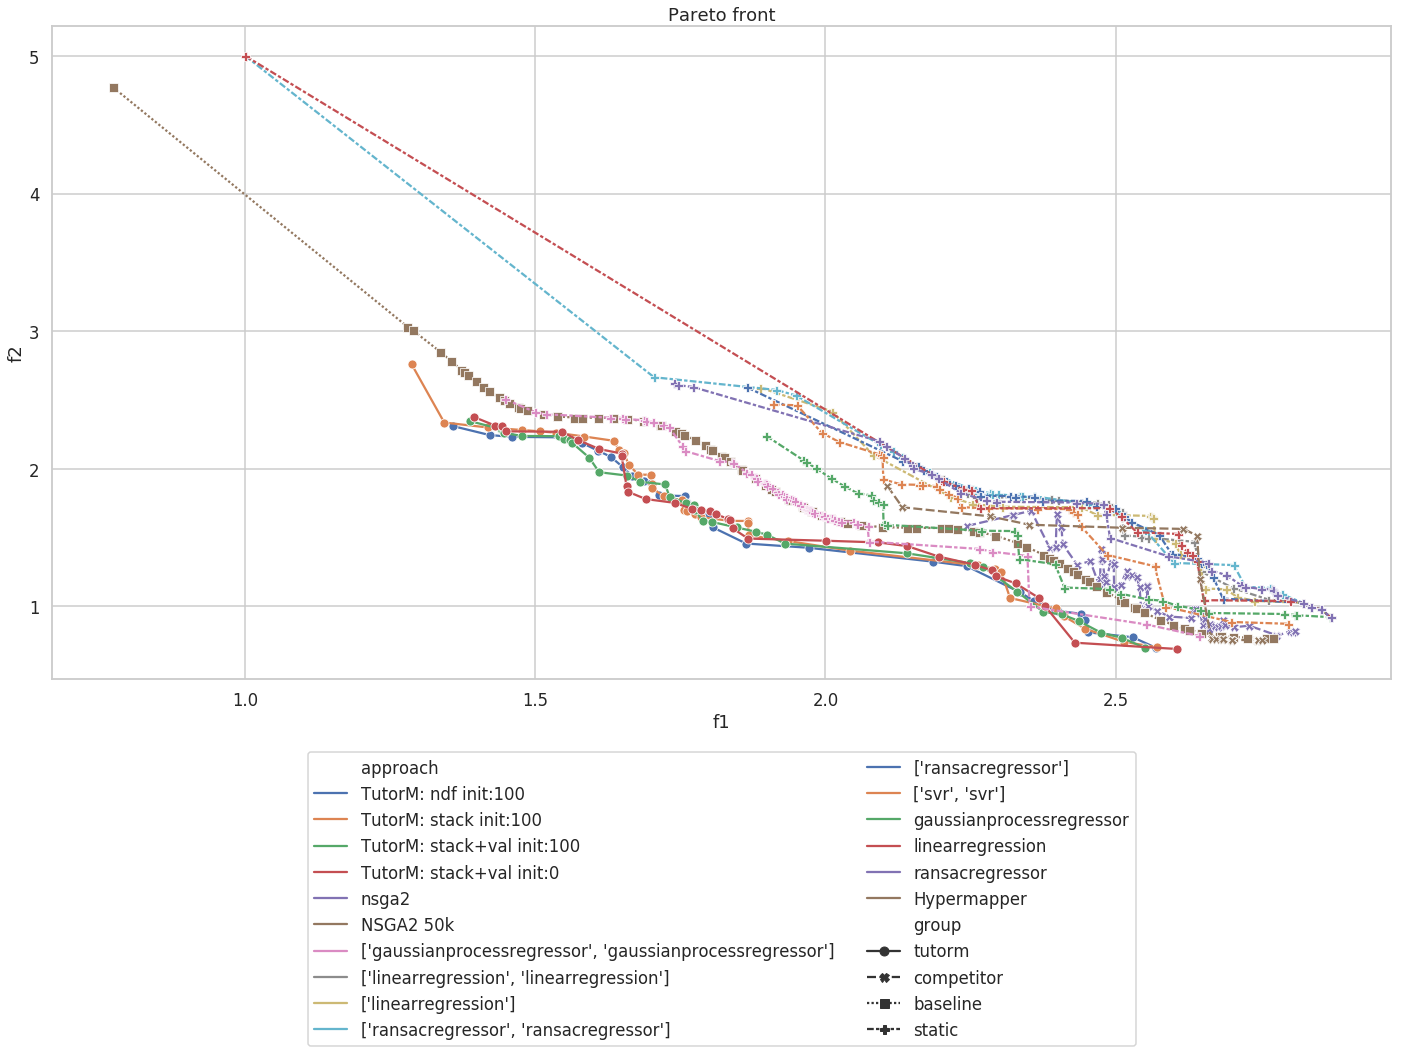

In [53]:
EXP_ORDER = 0 # 0-4

plt.figure(figsize=(24, 12))
summ = []
# --- TutorM
for temp_df in [b1_df, b2_df, b3_df, b4_df]:
    i_result = temp_df.query('i_fevals==1000').iloc[EXP_ORDER]
    temp_tutor = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'] )
    temp_tutor['approach'] = i_result.approach
    temp_tutor['group'] = 'tutorm'
    summ.append(temp_tutor)
    
# --- NSGA2    
temp_nsga2 = list(nsga2_df.query('i_fevals==1000').groupby('group_id'))[EXP_ORDER][1]
temp_nsga2 = temp_nsga2[['f1', 'f2', 'approach']]
temp_nsga2['group'] = 'competitor'

summ.append(temp_nsga2)


# --- [Baseline] NSGA2 50k    
temp_base = list(baseline_df.groupby('group_id'))[EXP_ORDER][1]
temp_base = temp_base[['f1', 'f2']]
temp_base['group'] = 'baseline'
temp_base['approach'] = 'NSGA2 50k'
summ.append(temp_base)


# --- Static models
for typle in list(fix_model.query('i_fevals==1000').groupby('model name')):
    i_result = typle[1].iloc[EXP_ORDER]
    temp_static = pd.DataFrame(i_result.pop_ndf_y, columns=['f1', 'f2'] )
    temp_static['approach'] = i_result.approach
    temp_static['group'] = 'static'
    summ.append(temp_static)
    
# --- Hypermapper
all_points = mapper_df.groupby('i_fevals').apply(lambda focus_df: focus_df.iloc[EXP_ORDER])
index_ndf, dl, dc, ndr = pg.fast_non_dominated_sorting(all_points[['f1','f2']].values)
temp_mapper = all_points.iloc[index_ndf[0]][['f1','f2','approach']]
temp_mapper['group'] = 'competitor'
summ.append(temp_mapper)

sns.lineplot(data=pd.concat(summ), x='f1', y='f2', markers=True, palette="deep", style="group", hue='approach').set_title("Pareto front")    
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=2)
plt.show(p)

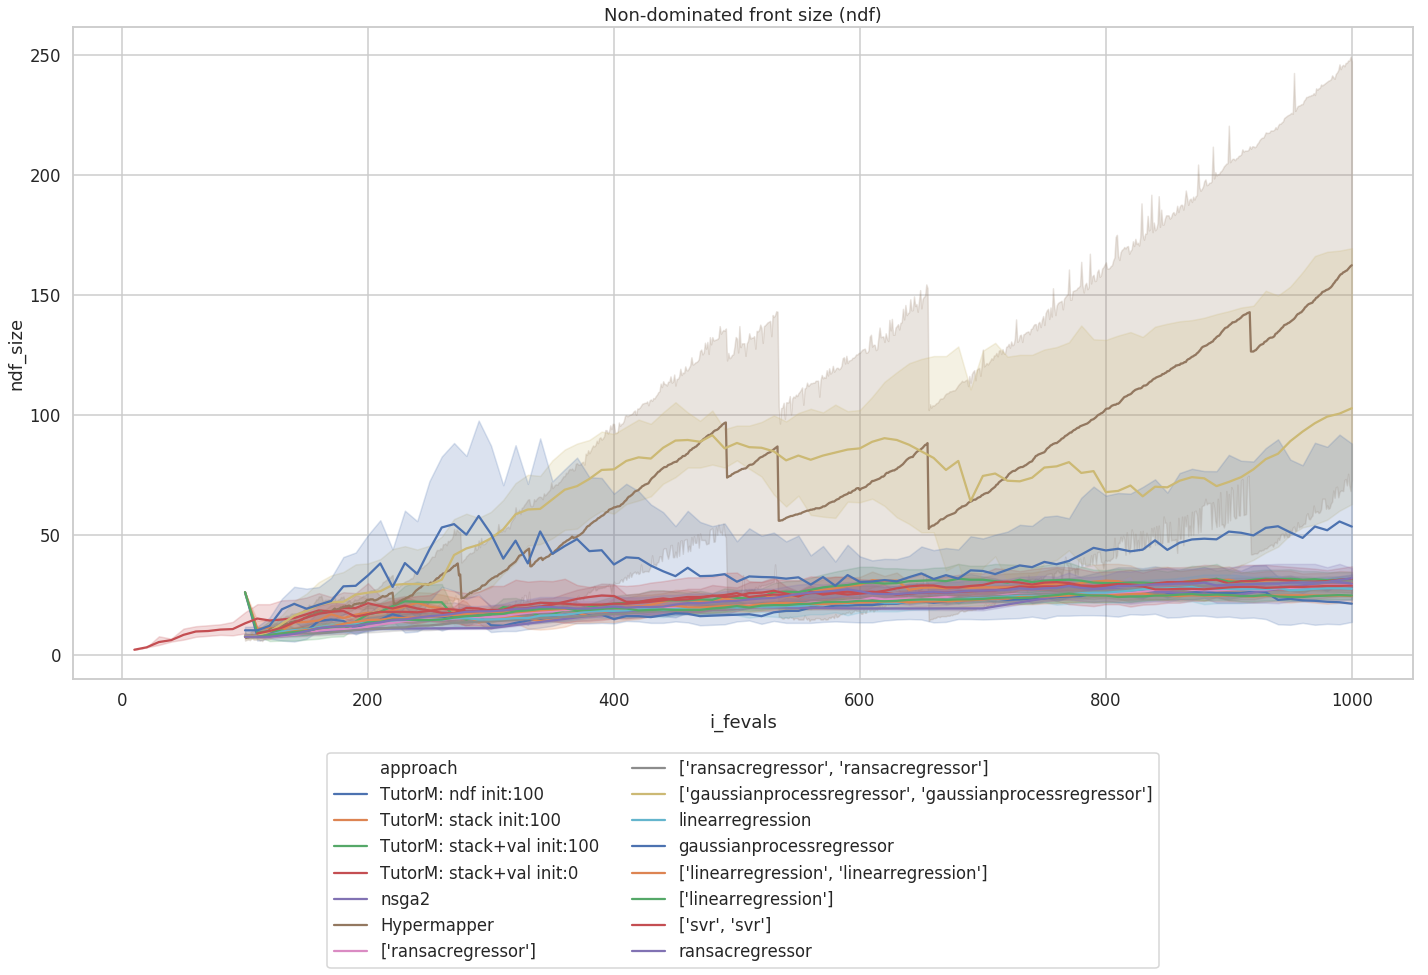

In [85]:
plt.figure(figsize=(24, 12))
sns.lineplot(x="i_fevals", y="ndf_size", hue="approach", 
             palette="deep",
#              style='group',
             data=pd.concat([b1_df, b2_df, b3_df, b4_df, nsga2_df, mapper_df, fix_model])).set_title("Non-dominated front size (ndf)")   
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),  ncol=2)
plt.show(p)

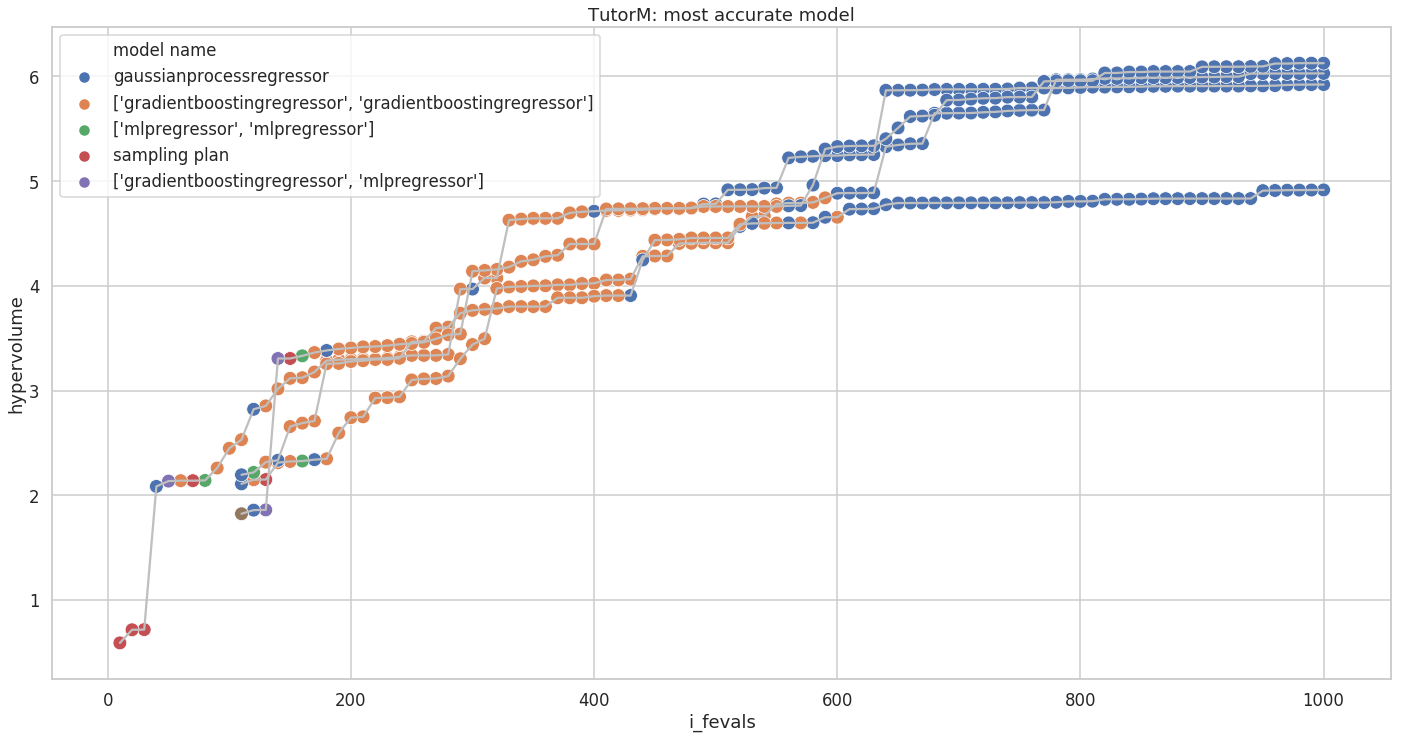

In [233]:
f, axes = plt.subplots(sharex='col', sharey='row', figsize=(24, 12))

for i, df_temp in enumerate([b4_df, b1_df, b2_df, b3_df]):
    
    df_temp = list(df_temp.groupby('tutor_id'))[EXP_ORDER][1]
    df_temp['model name'] = df_temp['model name'].astype(str)

    sns.lineplot(data=df_temp,
                 x="i_fevals", y="hypervolume",
#                  color='#eaedee',
                 color='#bfbfbf',
                )
    
    sns.scatterplot(data=df_temp,
                    x="i_fevals", y="hypervolume",
                    s=190,
                    hue="model name",
#                 marker='X',
                    ax=axes,
                    legend='brief' if i==0 else None,
                    palette="deep").set_title("TutorM: most accurate model") 



___
## WFG, ZDT, DTLZ
### 1. Summary table

In [2]:
df_group = [pd.read_csv(i_path, decimal=",") for i_path in glob.glob('tables/paper_*_summary.csv')]
table = pd.concat(df_group).query('problem!= DTLZ1 and problem!= DTLZ3')
table['group'] = table['problem'].apply(lambda prob: prob[0:-1])
table.drop('evolve_time', 1, inplace=True)
table.rename(columns={"hypervolume": "hypervolume_%"}, inplace=True)
table.groupby(['group', 'approach']).mean()

hypervolume_%  ndf_size_%  ndf_space  p_distance
group approach                                                     
DTLZ  Base_line        99.596000    0.257143   0.718629    0.172695
      Hypermapper      73.520079    1.862857   0.054939   24.159154
      NSGA2 1k         75.635090    5.414286   0.174829    1.269024
      TutorM           99.118503   40.822857   0.490928   12.924403
      [GPR, GPR]       99.409388   35.726429   0.509604    8.391852
      [GPR]            99.463697   35.304286   0.494280    6.041175
      [SVR]            99.061820   20.180000   0.415201   13.549067
WFG   Base_line        99.724661    0.288889   0.564093         NaN
      Hypermapper      75.887763    7.411111   0.101913         NaN
      NSGA2 1k         77.055729    8.764444   0.343329         NaN
      TutorM           97.651511   38.584444   0.785193         NaN
      [GPR, GPR]       91.906639   38.804863   0.791337         NaN
      [GPR]            92.771583   39.038338   0.771759         NaN
      [SVR]            84.220430   15.679272   0.319941         NaN
ZDT   Base_line        99.913898    0.384000   0.567430    0.000056
      Hypermapper      93.909686    7.684000   0.082305    0.455005
      NSGA2 1k         87.286702    7.616000   0.128593    0.278005
      TutorM           99.740479   63.498667   0.751178    0.019544
      [GPR, GPR]       99.437017   67.269000   0.679050    0.019610
      [GPR]            99.234632   62.036000   0.584866    0.082356
      [SVR]            98.122354   26.784000   0.171380    0.428299

### 2. Summary table. Except `DTLZ1` and `DTLZ3`

In [9]:
df_group = [pd.read_csv(i_path, decimal=",") for i_path in glob.glob('tables/paper_*_summary.csv')]
table = pd.concat(df_group).query('problem!= "DTLZ1" and problem!= "DTLZ3"')
table['group'] = table['problem'].apply(lambda prob: prob[0:-1])
table.drop('evolve_time', 1, inplace=True)
table.rename(columns={"hypervolume": "hypervolume_%"}, inplace=True)
table.groupby(['group', 'approach']).mean()

hypervolume_%  ndf_size_%  ndf_space  p_distance
group approach                                                     
DTLZ  Base_line        99.434400    0.264000   0.606080    0.001854
      Hypermapper      66.691448    2.312000   0.057741    0.527181
      NSGA2 1k         79.586319    7.104000   0.228311    0.235336
      TutorM           99.584736   56.964000   0.666729    0.024992
      [GPR, GPR]       99.276861   49.329000   0.688121    0.027566
      [GPR]            99.328668   48.546000   0.664034    0.024295
      [SVR]            99.022465   27.392000   0.570042    0.017467
WFG   Base_line        99.724661    0.288889   0.564093         NaN
      Hypermapper      75.887763    7.411111   0.101913         NaN
      NSGA2 1k         77.055729    8.764444   0.343329         NaN
      TutorM           97.651511   38.584444   0.785193         NaN
      [GPR, GPR]       91.906639   38.804863   0.791337         NaN
      [GPR]            92.771583   39.038338   0.771759         NaN
      [SVR]            84.220430   15.679272   0.319941         NaN
ZDT   Base_line        99.913898    0.384000   0.567430    0.000056
      Hypermapper      93.909686    7.684000   0.082305    0.455005
      NSGA2 1k         87.286702    7.616000   0.128593    0.278005
      TutorM           99.740479   63.498667   0.751178    0.019544
      [GPR, GPR]       99.437017   67.269000   0.679050    0.019610
      [GPR]            99.234632   62.036000   0.584866    0.082356
      [SVR]            98.122354   26.784000   0.171380    0.428299

In [10]:
table.groupby(['group', 'approach']).mean().to_csv('./table_summ_drop_wfg1_wfg3.csv', decimal=',')